# Regression

Estimating the price of a house, given real estate data (scalar regression)

The California Housing dataset is a modern, ethical, and well-documented alternative to the old Boston Housing data.
- Originally derived from the 1990 U.S. Census.
- Published in the StatLib repository and later adopted by scikit-learn.
- It describes housing values and demographic information for districts (block groups) in California.

Goal: To predict the median house value (in hundreds of thousands of dollars) for each California district based on census features.

## Get The Data 
### House Features
| Feature Name | Description                              | Type / Unit                                          |
| ------------ | ---------------------------------------- | ---------------------------------------------------- |
| `MedInc`     | Median income in the block group         | continuous, in tens of thousands (e.g., 3 = $30,000) |
| `HouseAge`   | Median age of houses                     | continuous, in years                                 |
| `AveRooms`   | Average number of rooms per household    | continuous                                           |
| `AveBedrms`  | Average number of bedrooms per household | continuous                                           |
| `Population` | Block group population                   | continuous                                           |
| `AveOccup`   | Average number of people per household   | continuous                                           |
| `Latitude`   | Latitude coordinate                      | continuous                                           |
| `Longitude`  | Longitude coordinate                     | continuous                                           |

### The House prices
| Target Name   | Description        | Unit                                                       |
| ------------- | ------------------ | ---------------------------------------------------------- |
| `MedHouseVal` | Median house value | in hundreds of thousands of dollars (e.g., 2.5 = $250,000) |



In [1]:
# !pip install scikit-learn

In [2]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing() #(as_frame=True) #get the data as pandas dataframe
X = california.data        #pandas.core.frame.DataFrame
y = california.target      #pandas.core.series.Series


In [3]:
print(len(X), len(y))

20640 20640


In [4]:
print(type(X), type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Split Data into Train, Validation and Test Set

In [5]:
from sklearn.model_selection import train_test_split

## Split into Train 80%, Validation 10% and Test Set 10%
from sklearn.model_selection import train_test_split

# Step 1: Split off train set first (e.g., 80% train and 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Step 2: Split remaining data into validation/test (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,   
    random_state=42,
    shuffle=True
)
print(X.shape, X_train.shape, X_val.shape, X_test.shape )

(20640, 8) (16512, 8) (2064, 8) (2064, 8)


## Data Normalization
Problem data took wildly different ranges. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), subtract the mean of the feature and divide by the standard deviation. As a result the feature is centered around 0 and has a unit standard deviation. 

In [6]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
print(X_train.shape)

mean = X_val.mean(axis=0)
std = X_val.std(axis=0)
X_val = (X_val - mean) / std
print(X_val.shape)

mean = X_test.mean(axis=0)
std = X_test.std(axis=0)
X_test = (X_test - mean) / std
print(X_test.shape)

(16512, 8)
(2064, 8)
(2064, 8)


## Convert Numpy Data into PyTorch Tensors 

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

# Convert NumPy arrays to PyTorch tensors and wrap tensors in a dataset
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train, dtype=torch.float32))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), 
                              torch.tensor(y_val, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                              torch.tensor(y_test, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #<-- no shuffle here!

print(len(train_loader), len(val_loader),  len(test_loader))
# Example: iterate through batches
#for batch_X, batch_y in loader:
#    print(batch_X.shape, batch_y.shape)
#    break  # just to show one batch


516 65 65


## Model Definition and Model Initialization

In [8]:
## Define two Models: One with two and one three linear layers
## Experiment with different activation functions

from torch import nn
import torch.nn.functional as F

class Linear2LayerModel(nn.Module):
    def __init__(self, input_dim, hidden=32, output_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden)   # First linear layer
        self.fc2 = nn.Linear(hidden, output_dim)  # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Activation after first layer
        x = self.fc2(x)          # Output layer (no activation for regression)
        return x

class Linear3LayerModel(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, output_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)   # First linear layer
        self.fc2 = nn.Linear(hidden1, hidden2)     # Second linear layer
        self.fc3 = nn.Linear(hidden2, output_dim)  # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Activation after first layer
        x = F.relu(self.fc2(x))  # Activation after second layer
        x = self.fc3(x)          # Output layer (no activation for regression)
        return x


In [9]:
## Initialize the model 
## Start with the smaller 2-layer model
model = Linear3LayerModel(input_dim=8, hidden1=64, hidden2=32, output_dim=1)
#model = Linear2LayerModel(input_dim=8, hidden=32, output_dim=1)
model

Linear3LayerModel(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [10]:
#check the parameter
for name, param in model.named_parameters():
    print(name, param.shape)

fc1.weight torch.Size([64, 8])
fc1.bias torch.Size([64])
fc2.weight torch.Size([32, 64])
fc2.bias torch.Size([32])
fc3.weight torch.Size([1, 32])
fc3.bias torch.Size([1])


## Define Loss Function and Optimizer

In [11]:
# use mean squared error as loss function
import torch.optim as optim

# Start with high learning rate and 
learning_rate = 0.0001
criterion =  nn.MSELoss() # Use for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 

# Use a different loss function for validation: MAE

## Start the Training Loop

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

#set model to divice
model.to(device)

mps


Linear3LayerModel(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
from datetime import datetime

train_history = []
val_history = []

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y) #Use outputs.squeeze() to match shape of y if y is 1D.
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    train_history.append(avg_loss)
    
    # ----- “Validation” check on validation set -----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_history.append(val_loss)
    
    

    #save the parameters of model after each epoch
    t = datetime.now().replace(microsecond=0).isoformat().replace(":","-")
    model_filename = f"models/regression_{epoch}_{t}_model_weights.pth"
    torch.save(model.state_dict(), model_filename)
    
    print(f"Epoch [{epoch+1}/{epochs}], Train-Loss: {avg_loss:.4f}. Validation Loss = {val_loss:.4f} Saved {model_filename}")

Epoch [1/10], Train-Loss: 2.5603. Validation Loss = 1.0701 Saved models/regression_0_2025-10-19T08-51-32_model_weights.pth
Epoch [2/10], Train-Loss: 0.9790. Validation Loss = 0.7748 Saved models/regression_1_2025-10-19T08-51-33_model_weights.pth
Epoch [3/10], Train-Loss: 0.7710. Validation Loss = 0.6390 Saved models/regression_2_2025-10-19T08-51-35_model_weights.pth
Epoch [4/10], Train-Loss: 0.6730. Validation Loss = 0.5754 Saved models/regression_3_2025-10-19T08-51-36_model_weights.pth
Epoch [5/10], Train-Loss: 0.6064. Validation Loss = 0.5386 Saved models/regression_4_2025-10-19T08-51-37_model_weights.pth
Epoch [6/10], Train-Loss: 0.5489. Validation Loss = 0.5215 Saved models/regression_5_2025-10-19T08-51-39_model_weights.pth
Epoch [7/10], Train-Loss: 0.5043. Validation Loss = 0.5266 Saved models/regression_6_2025-10-19T08-51-40_model_weights.pth
Epoch [8/10], Train-Loss: 0.4711. Validation Loss = 0.5643 Saved models/regression_7_2025-10-19T08-51-41_model_weights.pth
Epoch [9/10], Tr

In [14]:
# !pip install matplotlib

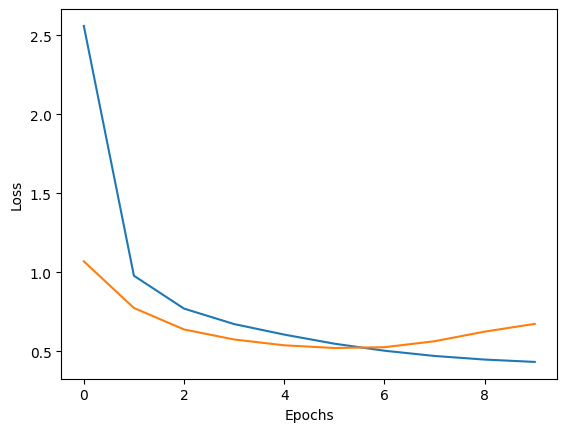

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_history)
plt.plot(range(epochs), val_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

IF YOU WANT TO RETRAIN THE MODEL THEN GO BACK TO CELL "MODEL INITIALIZATION"

## Overfitting

IF STARTING WITH A HIGH LEARNING RATE lr = 0.001 THEN THEN VALIDATION LOSS IS STEADILY INCREASING

- Train loss decreasing --> model is learning to fit the training data.
- Validation loss increase --> model is failing to generalize to unseen data.

Overfitting happens when your model learns the training data too well, including its noise and random fluctuations, instead of learning the general underlying patterns.

### What are the reasons and what could we change?
- Model complexity is too high relative to the amount of data: Too many parameters for small dataset?
- Insufficient regularization: No weight decay (L2), dropout, or other constraints.
- Too many epochs: the model memorizes training data rather than generalizing.
- Small training dataset: fewer samples make overfitting happen faster.
- Learning rate might be too high: can cause validation loss to oscillate or diverge.

| Strategy                        | Description                                            |
| ------------------------------- | ------------------------------------------------------ |
| 🧩 **Simplify model**           | Reduce hidden layer size or depth                      |
| 🧹 **Regularization**           | Add L2 weight decay (`weight_decay` in Adam), or L1    |
| 🎲 **Dropout**                  | Add dropout layers (`nn.Dropout(p=0.3)`)               |
| 🛑 **Early stopping**           | Stop when validation loss stops improving              |
| 📈 **More data / augmentation** | Increase sample diversity                              |
| ⚖️ **Cross-validation**         | Use multiple splits for better generalization estimate |
| ⚙️ **Normalization**            | Scale features and targets properly                    |
| 🧮 **Reduce training epochs**   | Avoid over-training                                    |


In [19]:
# Use Test Set for Final Check
Linear3LayerModel(input_dim=8, hidden1=64, hidden2=32, output_dim=1)  # initialize the same model!!

# Load the stored parameters with best validation loss
model_filename = "models/regression_5_2025-10-19T08-51-39_model_weights.pth"
model.load_state_dict(torch.load(model_filename))
model.eval()

test_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f"MSE: {test_loss:.4f}.")

MSE: 0.4817.


## ------------- Backup ---------------

## Data Cleaning

Eliminate None Values. For that concat X any and drop all lines with missing values 

In [29]:
import pandas as pd

data = pd.concat([X, y], axis=1)

# Drop rows with any missing values
data = data.dropna()

# Split back into X and y
X_clean = data.drop(y.name, axis=1)
y_clean = data[y.name]

In [33]:
print(len(X_clean), len(y_clean))

20640 20640


In [ ]:
# If data are numpy arrays
import numpy as np
mask = np.isnan(X_clean) # Get a boolean mask of NaNs

# Count NaNs per column (same as X_clean.isna().sum() in pandas)
nan_per_column = np.sum(mask, axis=0)
print(nan_per_column)